In [3]:
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
from fastbook import *
# from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from matplotlib import pyplot as plt
import joblib
pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
dep_var= 'human_scored_rear'
base = Path('F:\\Users\\Gittis\\Dropbox\\Gittis Lab Data\\OptoBehavior\\DLC Examples\\train_rear_model\\')
#base = Path('/home/brian/Dropbox/Gittis Lab Data/OptoBehavior/DLC Examples/train_rear_model/')

In [74]:
# Load in data .csv collated by model.py 
df = pd.read_csv(base/'Train_v3.csv', #V2 stable, trying V3 3/25/21
                low_memory = False)

df.drop('Unnamed: 0',axis = 1, inplace =True)
df.fillna(method = 'ffill',inplace = True)
df.fillna(method = 'bfill',inplace = True)
train_len = len(df)
df_test=pd.read_csv(base/'Test_v3.csv',
                   low_memory = False)
df_test.drop('Unnamed: 0',axis = 1,inplace =True)
df_test.fillna(method = 'ffill',inplace=True)
df_test.fillna(method = 'bfill',inplace = True)

df_both=pd.concat([df,df_test])
df_both.reset_index(inplace=True)
#df_both.to_csv(base/'TrainAndValid.csv')
idx=df_both.iloc[:,0]
procs = [Categorify, FillMissing]

cond = (df_both.index< train_len )
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

print('Train = %d == %d' % (len(train_idx),train_len))
print('Test = %d' % len(valid_idx))
print('Sum = %d == Total Len %d ' % (len(train_idx) + len(valid_idx), len(idx)))

Train = 95356 == 95356
Test = 70153
Sum = 165509 == Total Len 165509 


In [75]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df_both, procs, cat, cont, y_names=dep_var, splits=splits)
save_pickle(base/'to_v3.pkl',to)

In [4]:
to = load_pickle(base/'to_v3.pkl')
#to = load_pickle(base/'to.pkl')

In [9]:
draw_tree??

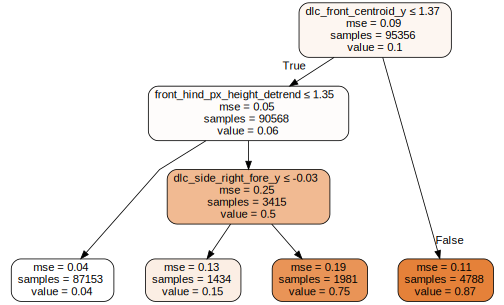

In [5]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

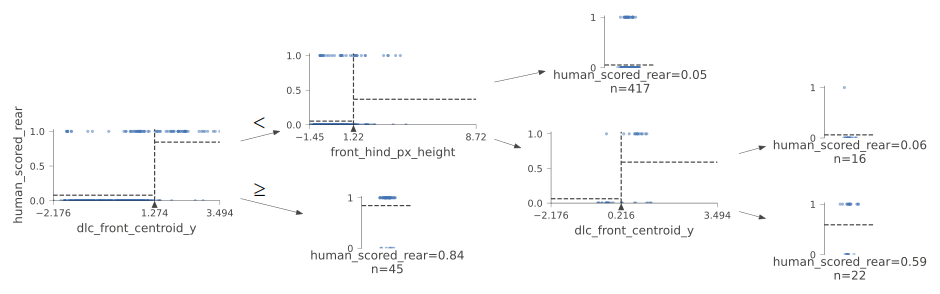

In [8]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [54]:
m = DecisionTreeRegressor(min_samples_leaf=15)
m.fit(to.train.xs, to.train.y)
brier_train=metrics.brier_score_loss(y, m.predict(xs))
print(brier_train)
brier_valid=metrics.brier_score_loss(valid_y, m.predict(valid_xs))
print(brier_valid)
brier_rand=metrics.brier_score_loss(valid_y,np.random.rand(valid_xs.shape[0]))
print('%1.2f, perf = %2.1fx better than chance.' % (brier_rand, brier_rand / brier_valid))

0.01349859387010966
0.04966780771644348
0.33, perf = 6.7x better than chance.


In [13]:
'''
In the following function definition 
n_estimators defines the number of trees we want,
max_samples defines how many rows to sample for training each tree, and
max_features defines how many columns to sample at each split point 
(where 0.5 means "take half the total number of columns"). 
We can also specify when to stop splitting the tree nodes, 
effectively limiting the depth of the tree, 
by including the same min_samples_leaf parameter we used in the last section. 
Finally, we pass n_jobs=-1 to tell sklearn to use all our CPUs to build the trees in parallel.
By creating a little function for this, we can more quickly try different variations in the 
rest of this chapter:
'''

'\nIn the following function definition \nn_estimators defines the number of trees we want,\nmax_samples defines how many rows to sample for training each tree, and\nmax_features defines how many columns to sample at each split point \n(where 0.5 means "take half the total number of columns"). \nWe can also specify when to stop splitting the tree nodes, \neffectively limiting the depth of the tree, \nby including the same min_samples_leaf parameter we used in the last section. \nFinally, we pass n_jobs=-1 to tell sklearn to use all our CPUs to build the trees in parallel.\nBy creating a little function for this, we can more quickly try different variations in the \nrest of this chapter:\n'

In [55]:
def rf(xs, y, n_estimators=60, max_samples=70_000,
       max_features=0.5, min_samples_leaf=4, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)


In [95]:
m = rf(xs, y,min_samples_leaf = 125,max_samples = 30_000, n_estimators = 100);
brier_train=metrics.brier_score_loss(y, m.predict(xs))
print(brier_train)
brier_valid=metrics.brier_score_loss(valid_y, m.predict(valid_xs))
print(brier_valid)
brier_rand=metrics.brier_score_loss(valid_y,np.random.rand(valid_xs.shape[0]))
train_rsq=m.oob_score_
valid_rsq=metrics.r2_score(valid_y, m.predict(valid_xs))
print('OOB R^2= %1.2f, Valid R^2 = %1.2f, Brier = %2.1fx chance.' % (m.oob_score_,valid_rsq, brier_rand / brier_valid))

0.02782725521691257
0.028326092947292804
OOB R^2= 0.67, Valid R^2 = 0.64, Brier = 11.8x chance.


In [137]:
print(xs.shape)
print(type(xs))

(95356, 32)
<class 'pandas.core.frame.DataFrame'>


In [101]:
#How to save random forest model?

joblib.dump(m, base/'rf_model_v3.joblib')

['F:\\Users\\Gittis\\Dropbox\\Gittis Lab Data\\OptoBehavior\\DLC Examples\\train_rear_model\\rf_model_v3.joblib']

In [230]:
for min_samps in range(5,500,10):
    m = rf(xs, y,min_samples_leaf = min_samps,max_samples = 25_000, n_estimators = 20);
    valid_rsq=metrics.r2_score(valid_y, m.predict(valid_xs))
    brier_valid=metrics.brier_score_loss(valid_y, m.predict(valid_xs))
    brier_rand=metrics.brier_score_loss(valid_y,np.random.rand(valid_xs.shape[0]))
    print('%d, OOB R^2= %1.2f, Valid R^2 = %1.2f, Brier = %2.1fx chance.' % (min_samps, m.oob_score_,valid_rsq, brier_rand / brier_valid))

5, OOB R^2= 0.82, Valid R^2 = 0.55, Brier = 10.1x chance.
15, OOB R^2= 0.78, Valid R^2 = 0.59, Brier = 11.1x chance.
25, OOB R^2= 0.76, Valid R^2 = 0.60, Brier = 11.3x chance.
35, OOB R^2= 0.75, Valid R^2 = 0.62, Brier = 11.7x chance.
45, OOB R^2= 0.74, Valid R^2 = 0.59, Brier = 11.0x chance.
55, OOB R^2= 0.73, Valid R^2 = 0.59, Brier = 10.9x chance.
65, OOB R^2= 0.73, Valid R^2 = 0.63, Brier = 12.0x chance.
75, OOB R^2= 0.72, Valid R^2 = 0.61, Brier = 11.7x chance.
85, OOB R^2= 0.71, Valid R^2 = 0.61, Brier = 11.7x chance.
95, OOB R^2= 0.71, Valid R^2 = 0.62, Brier = 11.7x chance.
105, OOB R^2= 0.71, Valid R^2 = 0.62, Brier = 11.8x chance.
115, OOB R^2= 0.70, Valid R^2 = 0.61, Brier = 11.6x chance.
125, OOB R^2= 0.70, Valid R^2 = 0.64, Brier = 12.4x chance.
135, OOB R^2= 0.70, Valid R^2 = 0.62, Brier = 11.9x chance.
145, OOB R^2= 0.70, Valid R^2 = 0.62, Brier = 11.7x chance.
155, OOB R^2= 0.69, Valid R^2 = 0.60, Brier = 11.3x chance.
165, OOB R^2= 0.69, Valid R^2 = 0.61, Brier = 11.6x

KeyboardInterrupt: 

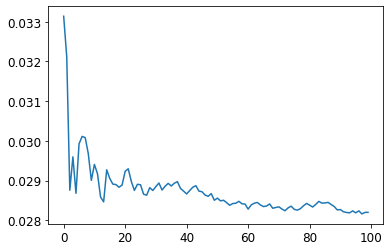

In [232]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
plt.plot([metrics.brier_score_loss(valid_y,preds[:i+1].mean(0)) for i in range(100)]);

In [144]:
# Out-of-bag error is more accurate estimate of training set performance
# Can make a validation set unnecessary for small datasets:
metrics.brier_score_loss(y,m.oob_prediction_)

0.014691514147202746

In [18]:
# Std dev. across trees tells something about confidence about predicting a given row:
preds_std = preds.std(0)
preds_std[:5]

array([0.05969925, 0.13319188, 0.        , 0.        , 0.23506806])

In [58]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

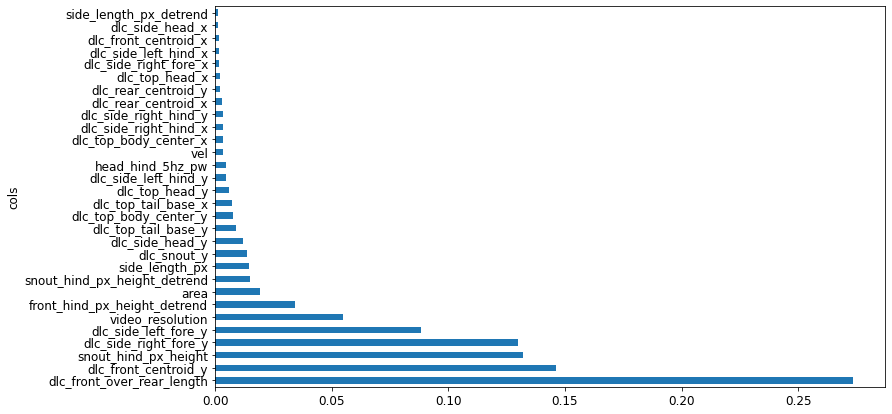

In [59]:
fi = rf_feat_importance(m, xs)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [222]:
# Can re-train using only the columns with importance > 0.005 or some threshold value:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)


20

In [223]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [224]:
# m = rf(xs_imp, y)
m = rf(xs_imp, y,min_samples_leaf = 200,max_samples = 70_000, n_estimators = 55);

In [225]:
brier_valid=metrics.brier_score_loss(valid_y, m.predict(valid_xs_imp))
brier_rand=metrics.brier_score_loss(valid_y,np.random.rand(valid_xs_imp.shape[0]))
train_rsq=m.oob_score_
valid_rsq=metrics.r2_score(valid_y, m.predict(valid_xs_imp))
print('OOB R^2= %1.2f, Valid R^2 = %1.2f, Brier = %2.1fx chance.' % (m.oob_score_,valid_rsq, brier_rand / brier_valid))

OOB R^2= 0.71, Valid R^2 = 0.62, Brier = 11.9x chance.


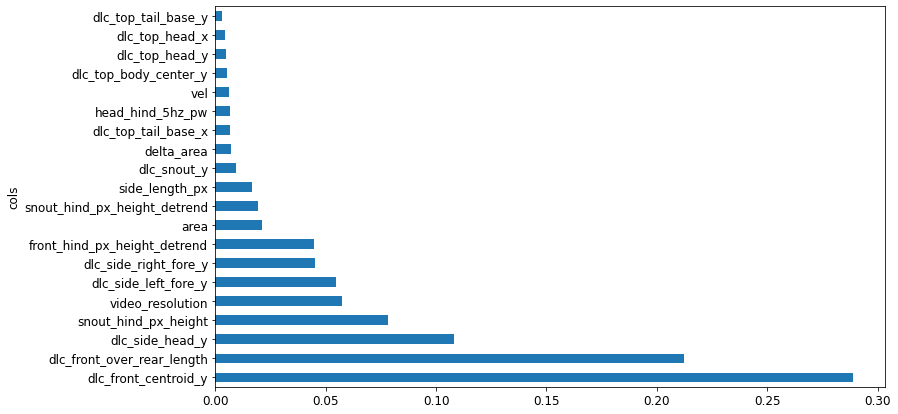

In [226]:
plot_fi(rf_feat_importance(m, xs_imp));

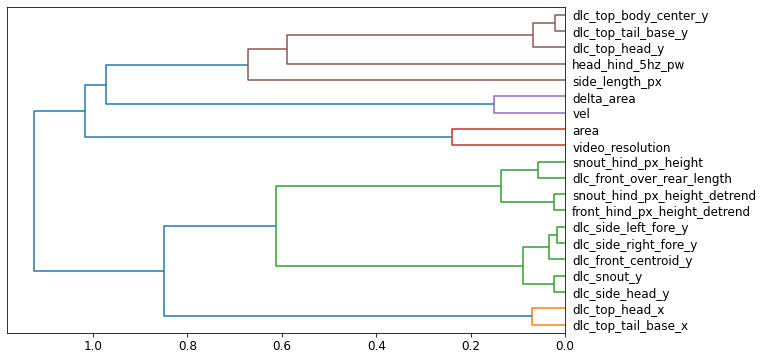

In [227]:
cluster_columns(xs_imp)

In [146]:
'''

Let's try removing some of these closely related features
to see if the model can be simplified without impacting the accuracy.
First, we create a function that quickly trains a random forest and returns the OOB score,
by using a lower max_samples and higher min_samples_leaf. 
The OOB score is a number returned by sklearn that ranges between 1.0 for a perfect model and 0.0 
for a random model. (In statistics it's called R^2,
although the details aren't important for this explanation.)
We don't need it to be very accurate—we're just going to use it to compare different models,
based on removing some of the possibly redundant columns:

'''
def get_oob(df):
    m = RandomForestRegressor(n_estimators=60, min_samples_leaf=4,
        max_samples=70000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [228]:
get_oob(xs_imp) #Baseline

0.854784985462632

In [148]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'dlc_top_head_x','dlc_rear_centroid_x', 'dlc_side_head_x','dlc_front_centroid_x',
    'dlc_rear_centroid_x', 'dlc_snout_x',
    'dlc_top_tail_base_y','dlc_top_body_center_y')}

{'dlc_top_head_x': 0.8624064346373062,
 'dlc_rear_centroid_x': 0.8617609762495407,
 'dlc_side_head_x': 0.8639996260349172,
 'dlc_front_centroid_x': 0.8636854815459976,
 'dlc_snout_x': 0.8631735938309966,
 'dlc_top_tail_base_y': 0.8613652102928231,
 'dlc_top_body_center_y': 0.8623428575025184}

In [150]:
to_drop = ['dlc_front_centroid_x','dlc_side_head_y','dlc_rear_centroid_x','dlc_top_head_x', 'dlc_side_head_x',]
get_oob(xs_imp.drop(to_drop, axis=1))

0.8595210813570036

In [167]:
xs_final = xs_imp #.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp #.drop(to_drop, axis=1)
save_pickle(base/'xs_final.pkl',xs_final)
save_pickle(base/'valid_xs_final.pkl',valid_xs_final)

In [126]:
xs_final = load_pickle(base/'xs_final.pkl')
valid_xs_final = load_pickle(base/'valid_xs_final.pkl')

In [197]:
# Check that model still performs well with fewer columns:

m = rf(xs_final, y, min_samples_leaf = 25,max_samples = 25_000, n_estimators = 100)

brier_train=metrics.brier_score_loss(y,m.oob_prediction_)
print(brier_train)
brier_valid=metrics.brier_score_loss(valid_y, m.predict(valid_xs_final))
print(brier_valid)
brier_rand=metrics.brier_score_loss(valid_y,np.random.rand(valid_xs_final.shape[0]))
print('%1.2f, perf = %2.1fx better than chance.' % (brier_rand, brier_rand / brier_valid))

0.024215105785933635
0.02628029795705546
0.33, perf = 12.6x better than chance.


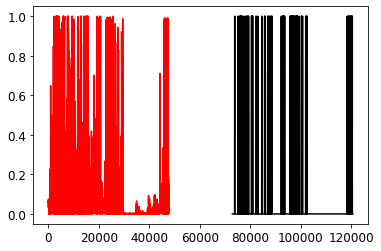

In [199]:
plt.plot(valid_y,'k')
plt.plot(m.predict(valid_xs_final),'r')

In [143]:
valid_y.to_csv(base/'obs_valid_rearv3.csv')
pred=pd.DataFrame({'pred':m.predict(to.valid.xs)})
pred.to_csv(base/'pred_valid_rearv3.csv')

y.to_csv(base/'obs_train_rearv3.csv')
pred=pd.DataFrame({'pred':m.predict(to.train.xs)})
pred.to_csv(base/'pred_train_rearv3.csv')

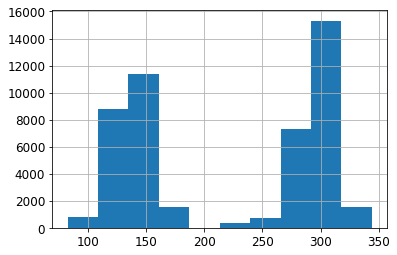

In [198]:
#Distribution of an important predictor:
ax = valid_xs_final['dlc_snout_y'].hist()

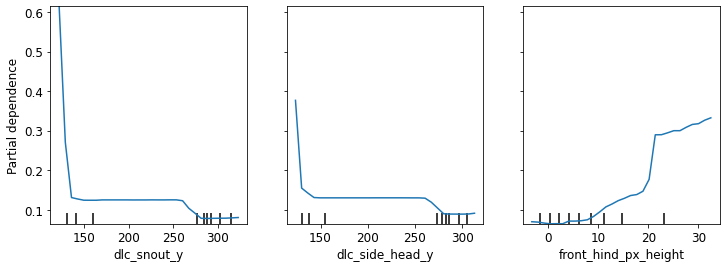

In [37]:
#Partial dependence:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['dlc_snout_y','dlc_side_head_y','front_hind_px_height'],
                        grid_resolution=30, ax=ax);

In [9]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [12]:
row = valid_xs_final.iloc[:5]
prediction,bias,contributions = treeinterpreter.predict(m, row.values)
prediction[0], bias[0], contributions[0].sum()

(array([0.]), 0.12213083333333337, -0.12213083333333334)

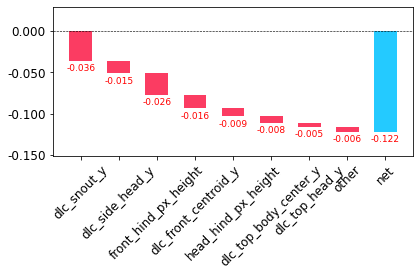

In [13]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

In [15]:
# Is your test set representative or does it have unique properties?
# Train a random forest to descriminate training from validation datasets
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:10]

,cols,imp
16,vel,0.071940
15,elon,0.069530
13,top_length_px,0.062506
5,side_length_px,0.062204
10,dlc_top_head_x,0.059248
11,area,0.058511
17,delta_area,0.056886
12,dlc_top_tail_base_x,0.055760
8,dlc_top_head_y,0.053757
9,dlc_rear_centroid_y,0.053688


In [29]:
df_dom.columns

Index(['dlc_snout_y', 'dlc_side_head_y', 'front_hind_px_height',
       'dlc_front_centroid_y', 'head_hind_px_height', 'side_length_px',
       'dlc_top_tail_base_y', 'dlc_top_body_center_y', 'dlc_top_head_y',
       'dlc_rear_centroid_y', 'dlc_top_head_x', 'area', 'dlc_top_tail_base_x',
       'top_length_px', 'dlc_top_body_center_x', 'elon', 'vel', 'delta_area'],
      dtype='object')

In [16]:
# Try removing one of these predictive columns
time_vars = ['vel']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)

brier_train=metrics.brier_score_loss(y,m.oob_prediction_)
print(brier_train)
brier_valid=metrics.brier_score_loss(valid_y, m.predict(valid_xs_time))
print(brier_valid)
brier_rand=metrics.brier_score_loss(valid_y,np.random.rand(valid_xs_time.shape[0]))
print('%1.2f, perf = %2.1fx better than chance.' % (brier_rand, brier_rand / brier_valid))

0.017167706628515494
0.016134694762997507
0.33, perf = 20.5x better than chance.


In [77]:
# Save train and valid in same .csv:
df = pd.read_csv(base/'Train_v3.csv',
                low_memory = False)
idx=df.iloc[:,0]
df.drop('Unnamed: 0',axis = 1, inplace =True)
df.fillna(method = 'ffill',inplace = True)
df_test=pd.read_csv(base/'Test_v3.csv',
                   low_memory = False)
df_test.drop('Unnamed: 0',axis = 1,inplace =True)
df_test.fillna(method = 'ffill',inplace=True)
df_both=pd.concat([df,df_test])
df_both.reset_index(inplace=True)
df_both.to_csv(base/'TrainAndValid3.csv')
len(df)

95356

In [124]:
for col in df.columns:
    print(col)

vel
area
delta_area
dlc_side_head_x
dlc_side_head_y
dlc_front_centroid_x
dlc_front_centroid_y
dlc_rear_centroid_x
dlc_rear_centroid_y
dlc_snout_x
dlc_snout_y
dlc_side_left_fore_x
dlc_side_left_fore_y
dlc_side_right_fore_x
dlc_side_right_fore_y
dlc_side_left_hind_x
dlc_side_left_hind_y
dlc_side_right_hind_x
dlc_side_right_hind_y
dlc_top_head_x
dlc_top_head_y
dlc_top_body_center_x
dlc_top_body_center_y
dlc_top_tail_base_x
dlc_top_tail_base_y
video_resolution
human_scored_rear
side_length_px
head_hind_5hz_pw
snout_hind_px_height
snout_hind_px_height_detrend
front_hind_px_height_detrend
side_length_px_detrend


In [233]:
df_both.to_csv(base/'TrainAndValid.csv')

In [17]:
df_both=pd.read_csv(base/'TrainAndValid2.csv')

In [ ]:
df_both=pd.read_csv(base/'TrainAndValid3.csv')

95356


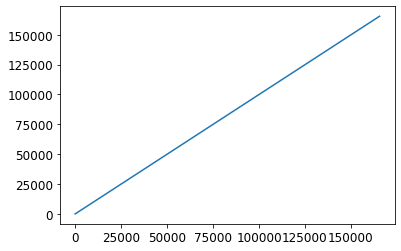

In [115]:
cond = (df_both.index< 95356)
print(np.sum(cond))
plt.plot(df_both.index)

# NN APPROACH (Now working)

In [116]:
#Neural network approach:
use_cols = ['dlc_snout_y', 'dlc_side_head_y', 'front_hind_px_height',
       'dlc_front_centroid_y', 'head_hind_px_height', 'side_length_px',
       'dlc_top_tail_base_y', 'dlc_top_body_center_y', 'dlc_top_head_y',
       'dlc_rear_centroid_y', 'dlc_top_head_x', 'area', 'dlc_top_tail_base_x',
       'top_length_px', 'dlc_top_body_center_x', 'elon', 'vel', 'delta_area']
#df_both=pd.read_csv(base/'TrainAndValid.csv')
train_len = len(df)
cond = (df_both.index< train_len )
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx),list(valid_idx))

exc = 'index'
use_cols = [col for col in df_both.columns if exc not in col]
df_nn_final=df_both[use_cols]

dep_var = 'human_scored_rear'

#df_nn_final[dep_var]=df_both[dep_var].astype(np.float32).values
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)
cat_nn.append(dep_var)
df_nn_final[cat_nn].nunique() #Identify dependent variable as categorical variable
cat_nn

['human_scored_rear']

In [63]:
df_nn_final.shape

(165509, 34)

In [64]:
len(splits[1])

70153

In [123]:
for col in df_both.columns:
    print(col)
print(len(df_both.columns))

index
vel
area
delta_area
dlc_side_head_x
dlc_side_head_y
dlc_front_centroid_x
dlc_front_centroid_y
dlc_rear_centroid_x
dlc_rear_centroid_y
dlc_snout_x
dlc_snout_y
dlc_side_left_fore_x
dlc_side_left_fore_y
dlc_side_right_fore_x
dlc_side_right_fore_y
dlc_side_left_hind_x
dlc_side_left_hind_y
dlc_side_right_hind_x
dlc_side_right_hind_y
dlc_top_head_x
dlc_top_head_y
dlc_top_body_center_x
dlc_top_body_center_y
dlc_top_tail_base_x
dlc_top_tail_base_y
video_resolution
human_scored_rear
side_length_px
head_hind_5hz_pw
snout_hind_px_height
snout_hind_px_height_detrend
front_hind_px_height_detrend
side_length_px_detrend
34


In [117]:
procs_nn = [FillMissing, Categorify, Normalize] #Categorify  FillMissing,
y_block = CategoryBlock()
to_nn = TabularPandas(df_nn_final, procs_nn, None, cont_nn,
                      splits=splits, y_names=dep_var)

In [294]:
TabularPandas??

In [11]:
valid_xs,valid_y = to_nn.valid.xs,to_nn.valid.y

In [111]:
to_nn.train.xs

,vel_na,vel,area,delta_area,...,snout_hind_px_height,snout_hind_px_height_detrend,front_hind_px_height_detrend,side_length_px_detrend
0,2,-0.398823,1.561798,0.298114,...,-0.667090,-0.690037,-0.629590,-0.652360
1,1,-0.653426,1.561798,-0.954932,...,-0.666764,-0.689923,-0.629565,-0.652336
2,1,-0.187012,1.357293,-0.221239,...,-0.664013,-0.688691,-0.628450,-0.649987
3,1,-0.567734,1.249011,-0.254214,...,-0.735360,-0.713717,-0.651045,-0.648749
4,1,-0.406680,1.281084,-0.460308,...,-0.816115,-0.742120,-0.678512,-0.644713
...,...,...,...,...,...,...,...,...,...
95351,1,-0.581937,-0.550010,-0.881209,...,-0.824411,-0.744103,-0.687235,-0.932400
95352,1,-0.606330,-0.532087,-0.918070,...,-0.837332,-0.748777,-0.694053,-0.884823
95353,1,-0.566307,-0.550010,-0.844348,...,-0.837332,-0.748788,-0.694080,-0.884999
95354,1,-0.584328,-0.567970,-0.844348,...,-0.837332,-0.748780,-0.694059,-0.884860


In [125]:
save_pickle(base/'to_nnv3.pkl',to_nn)

In [126]:
#trn_dl = TabDataLoader(to_nn.train, bs=64, shuffle=True, drop_last=True)
#val_dl = TabDataLoader(to_nn.valid, bs=128)
dls = to_nn.dataloaders(1024)

In [242]:
from fastai.tabular.all import *

In [127]:
learn = tabular_learner(dls, metrics=accuracy) #BrierScore doesn't seem to work with lr_find()

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.002511886414140463)

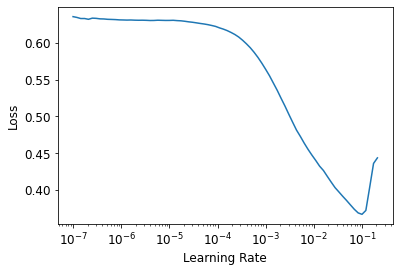

In [128]:
learn.lr_find()

In [130]:
#V3 data
learn = tabular_learner(dls, metrics=accuracy) #BrierScore doesn't seem to work with lr_find()
learn.fit_one_cycle(2, 2.5e-3)
learn.fit_one_cycle(2,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.158047,0.115562,0.967742,00:01
1,0.110524,0.115667,0.967884,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.103903,0.114071,0.968241,00:01
1,0.102213,0.113737,0.967899,00:01


In [87]:
#On v2 data:
learn = tabular_learner(dls, metrics=accuracy) #BrierScore doesn't seem to work with lr_find()
learn.fit_one_cycle(2, 2.5e-3)
learn.fit_one_cycle(2,1e-4)
learn.fit_one_cycle(4,1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.162959,0.112572,0.967927,00:01
1,0.112792,0.108095,0.968797,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.103376,0.109240,0.968483,00:01
1,0.101009,0.108661,0.968497,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.101939,0.109140,0.968269,00:01
1,0.102519,0.108561,0.968469,00:01
2,0.100142,0.110077,0.968184,00:01
3,0.100916,0.109080,0.968284,00:01


In [131]:
preds,targs = learn.get_preds()
valid_rsq=metrics.r2_score(targs,preds[:,1])
brier_valid=metrics.brier_score_loss(targs,preds[:,1])
brier_rand=metrics.brier_score_loss(targs,np.random.rand(targs.shape[0]))
print('Valid R^2 = %1.4f, Brier = %2.1fx chance.' % (valid_rsq, brier_rand / brier_valid))

Valid R^2 = 0.6469, Brier = 12.1x chance.


In [132]:
learn.save(base/'bi_rearing_nn_weightsv3') #This only saves the weights

Path('F:/Users/Gittis/Dropbox/Gittis Lab Data/OptoBehavior/DLC Examples/train_rear_model/bi_rearing_nn_weightsv3.pth')

In [133]:
 learn.export(base/'full_rear_model_v3.nn')

In [46]:
# Test loading:
learner = load_learner(base/'full_rear_model_v1.nn')

In [138]:

pred=pd.DataFrame({'pred':preds[:,1]})
pred.to_csv(base/'nn_pred_valid_rear_v3.csv')

In [139]:
train_df = pd.DataFrame(to_nn.train.xs)
#What are the predictions on the training data itself?
dl = learn.dls.test_dl(train_df, bs=64) # apply transforms
train_preds,  _ = learn.get_preds(dl=dl) # get prediction
tp=pd.DataFrame({'pred':train_preds[:,1]})
tp.to_csv(base/'nn_train_pred_rear_v3.csv')
print('Finished')

Finished


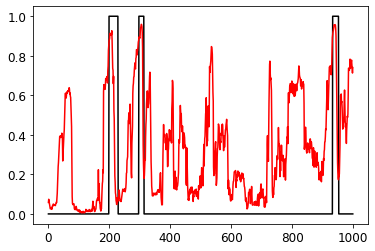

In [43]:
p = to_np(train_preds[:,1])
t = to_nn.train.y
plt.plot(t[0:1000],'k')
plt.plot(p[0:1000],'r')

In [140]:
#Ensembling on validation set:
rf_preds = m.predict(valid_xs)
ens_preds = (to_np(preds[:,1]) + rf_preds) /2

pred=pd.DataFrame({'pred':ens_preds})
pred.to_csv(base/'nn_rf_ens_pred_valid_rear_v3.csv')


In [144]:
#Ensembling on training set:
rf_preds = m.predict(to.train.xs)
dl = learn.dls.test_dl(to_nn.train.xs, bs=64) # apply transforms
train_preds,  _ = learn.get_preds(dl=dl) # get prediction
ens_preds = (to_np(train_preds[:,1]) + rf_preds) /2

pred=pd.DataFrame({'pred':ens_preds})
pred.to_csv(base/'nn_rf_ens_pred_train_rear_v3.csv')

In [141]:

valid_xs,valid_y = to.valid.xs,to.valid.y
rf_preds = m.predict(valid_xs)
ens_preds = (to_np(preds[:,1]) + rf_preds) /2
valid_rsq=metrics.r2_score(targs,ens_preds)
preds,targs = learn.get_preds()

brier_valid=metrics.brier_score_loss(targs,ens_preds)
brier_rand=metrics.brier_score_loss(targs,np.random.rand(targs.shape[0]))
print('Valid R^2 = %1.4f, Brier = %2.1fx chance.' % (valid_rsq, brier_rand / brier_valid))

Valid R^2 = 0.6572, Brier = 12.5x chance.


In [108]:
for col in valid_xs.columns:
    print(col)

vel
area
delta_area
dlc_side_head_x
dlc_side_head_y
dlc_front_centroid_x
dlc_front_centroid_y
dlc_rear_centroid_x
dlc_rear_centroid_y
dlc_snout_x
dlc_snout_y
dlc_side_left_fore_x
dlc_side_left_fore_y
dlc_side_right_fore_x
dlc_side_right_fore_y
dlc_side_left_hind_x
dlc_side_left_hind_y
dlc_side_right_hind_x
dlc_side_right_hind_y
dlc_top_head_x
dlc_top_head_y
dlc_top_body_center_x
dlc_top_body_center_y
dlc_top_tail_base_x
dlc_top_tail_base_y
video_resolution
side_length_px
head_hind_5hz_pw
snout_hind_px_height
snout_hind_px_height_detrend
front_hind_px_height_detrend
side_length_px_detrend
